In [1]:
!pip3 install -Uqq conllu tabulate

import conllu

with open('dev.conllu', 'r') as file:
    corpus = conllu.parse(file.read())

### Are all subtrees consecutive?
What are the stats on: size, child count, depth

ولم يكن من السهل عليه مواجهة كاميرات التلفزيون وعدسات المصورين وهو يصعد الباص . وقال بصوت خافت يكاد لا يسمع " الامر يخيفني بعض الشيء ( ... ) انها مفاجأة بالفعل . لن اكون متشردا بعد اليوم " .
وبعد ان ودع اصحابه وعناصر من الشرطة وابناء الحي الذي كان يبيت في شوارعه في العراء صعد الى الباص ليترك لونغ بيتش الواقعة على بعد ثلاثين كلم جنوب لوس انجليس بعد ان امضى فيها نحو عشرين عاما .


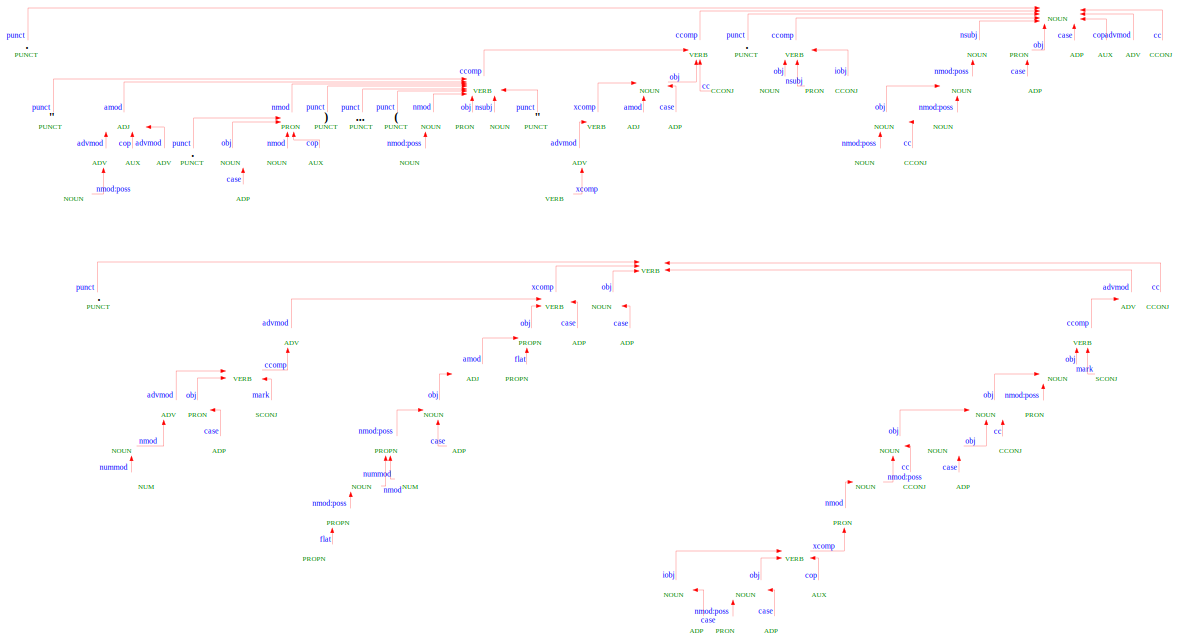

In [2]:
from graphviz import Digraph, nohtml

def _tree_draw(g, sent_id, node, depth):
    id_self = f"{sent_id}|{node.token['id']}"
    id_head = f"{sent_id}|{node.token['head']}"
    pos_x = -node.token['id'] / 3
    pos_y = -depth / 2
    g.node(
        id_self,
        label=f"<<b>{node.token}</b><br /><FONT POINT-SIZE='7' COLOR='green'>{node.token['upos']}</FONT>>",
        pos=f"{pos_x},{pos_y}!")
    if not id_head.endswith('|0'):
        g.edge(id_head, id_self, headlabel=node.token['deprel'])
    
    max_depth = depth
    for ch in node.children:
        max_depth = max(max_depth, _tree_draw(g, sent_id, ch, depth+1))
    return max_depth

def tree_draw(sentences):
    g = Digraph('G', engine="fdp",
                graph_attr={'splines': 'ortho', 'overlap': 'vpsc'},
                node_attr={'fontsize': '12', 'shape': 'plain'},
                edge_attr={'fontsize': '8', 'fontcolor': 'blue', 'color': 'red', 'arrowsize': '.5', 'dir': 'back', 'penwidth': '.25'})
    for sent in sentences:
        print(sent.metadata['text'])
    depth = 0
    for sent in sentences:
        sent_id = sent.metadata['sent_id'].replace(':', '#')
        with g.subgraph(name=sent_id) as c:
            depth = _tree_draw(c, sent_id, sent.to_tree(), depth) + 2
    return g

dbg_sent = corpus[3]
tree_draw(corpus[3:5])

In [3]:
from collections import defaultdict
import pandas as pd
import random

def query_subtree(sent, node, stats=None, depth=0, parent=None):
    def random_update(d, k, v):
        if d[k] == 0 or len(d[k]) > len(v):
            d[k] = v

    if stats is None:
        stats = defaultdict(lambda: defaultdict(lambda: 0))

    total_size = 1
    total_ids = set([node.token['id']])
    for ch in node.children:
        size, ids, stats = query_subtree(sent, ch, stats, depth+1, node)
        total_size += size
        total_ids = total_ids.union(ids)
        stats['upos>child'][f"{node.token['upos']}>{ch.token['upos']}"] += 1
    is_conseq = total_size == len(total_ids) and total_size == (max(total_ids) - min(total_ids) + 1)
    stats['is_conseq'][is_conseq] += 1
    stats['size'][total_size] += 1
    stats['depth'][depth] += 1
    stats['branching'][len(node.children)] += 1
    stats['upos'][node.token['upos']] += 1
    stats['deprel'][node.token['deprel']] += 1
    stats['upos>deprel'][f"{node.token['upos']}>{node.token['deprel']}"] += 1
    if node.token['head']:
        stats['upos>parent'][f"{node.token['upos']}>{parent.token['upos']}"] += 1
        stats['upos>deprel>parent'][f"{node.token['upos']}>{node.token['deprel']}>{parent.token['upos']}"] += 1
        random_update(stats['upos>deprel>parent.examples'], f"{node.token['upos']}>{node.token['deprel']}>{parent.token['upos']}", sent)
        stats['deprel>parent'][f"{node.token['deprel']}>{parent.token['upos']}"] += 1
        stats[f"parent_dist"][node.token['id'] - node.token['head']] += 1
        stats[f"parent_dist[{node.token['upos']}]"][node.token['id'] - node.token['head']] += 1
    return total_size, total_ids, stats

_, _, stats = query_subtree(dbg_sent, dbg_sent.to_tree())
for k, v in stats.items():
    print(f"{k} {dict(v)}")

is_conseq {True: 48}
size {1: 32, 2: 5, 3: 2, 5: 2, 6: 3, 4: 1, 21: 1, 29: 1, 48: 1}
depth {1: 10, 2: 8, 3: 15, 4: 11, 5: 3, 0: 1}
branching {0: 32, 1: 7, 2: 2, 3: 4, 4: 1, 10: 2}
upos {'CCONJ': 4, 'ADV': 4, 'AUX': 3, 'ADP': 4, 'PRON': 4, 'NOUN': 14, 'VERB': 5, 'PUNCT': 8, 'ADJ': 2}
deprel {'cc': 3, 'advmod': 4, 'cop': 3, 'case': 4, 'obj': 6, 'nmod:poss': 5, 'nsubj': 3, 'iobj': 1, 'ccomp': 3, 'punct': 8, 'amod': 2, 'xcomp': 2, 'nmod': 3, 'root': 1}
upos>deprel {'CCONJ>cc': 3, 'ADV>advmod': 4, 'AUX>cop': 3, 'ADP>case': 4, 'PRON>obj': 2, 'NOUN>nmod:poss': 5, 'NOUN>obj': 4, 'NOUN>nsubj': 2, 'CCONJ>iobj': 1, 'PRON>nsubj': 1, 'VERB>ccomp': 3, 'PUNCT>punct': 8, 'ADJ>amod': 2, 'VERB>xcomp': 2, 'NOUN>nmod': 2, 'PRON>nmod': 1, 'NOUN>root': 1}
upos>parent {'CCONJ>NOUN': 2, 'ADV>NOUN': 1, 'AUX>NOUN': 1, 'ADP>NOUN': 3, 'ADP>PRON': 1, 'PRON>NOUN': 1, 'NOUN>NOUN': 6, 'CCONJ>VERB': 2, 'PRON>VERB': 3, 'NOUN>VERB': 4, 'VERB>NOUN': 3, 'PUNCT>NOUN': 2, 'ADJ>NOUN': 1, 'VERB>ADV': 1, 'ADV>VERB': 1, 'PUNCT>

100%|██████████| 1986/1986 [00:00<00:00, 3253.90it/s]


defaultdict(<function query_subtree.<locals>.<lambda>.<locals>.<lambda> at 0x7f0ef11967a0>, {True: 73928, False: 17})


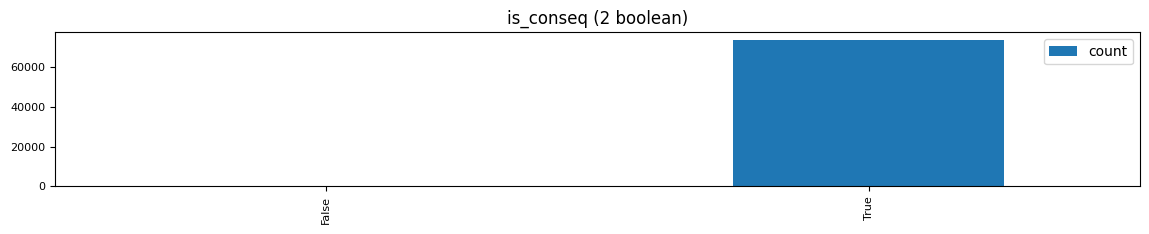

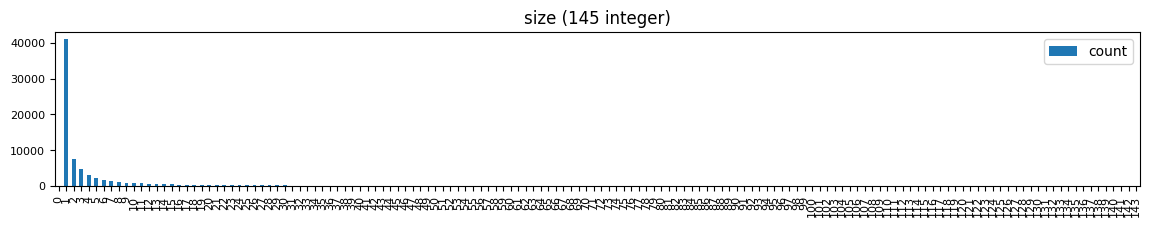

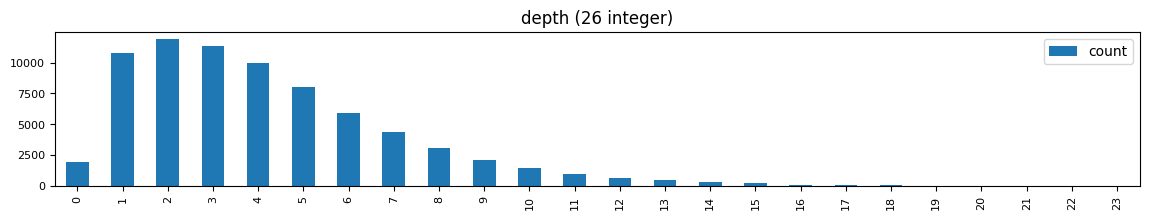

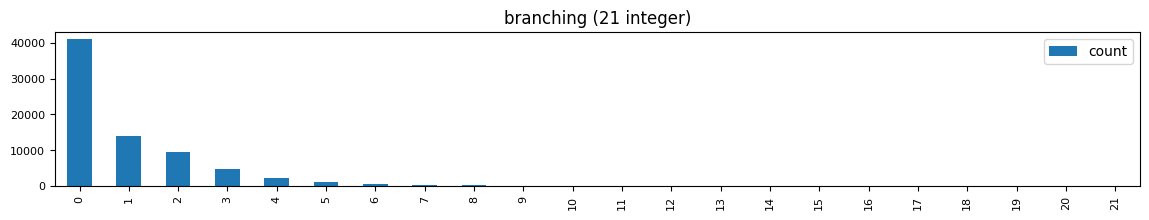

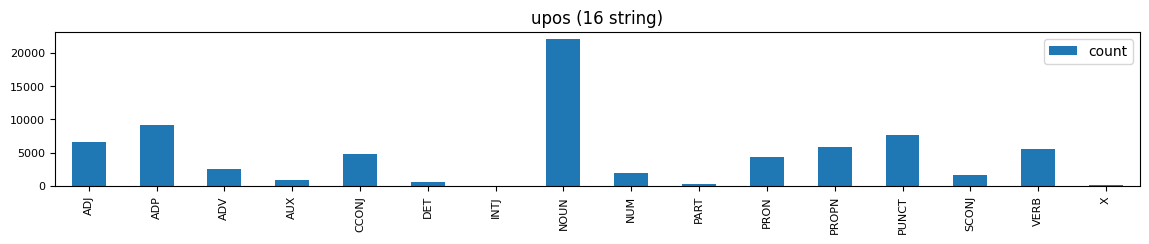

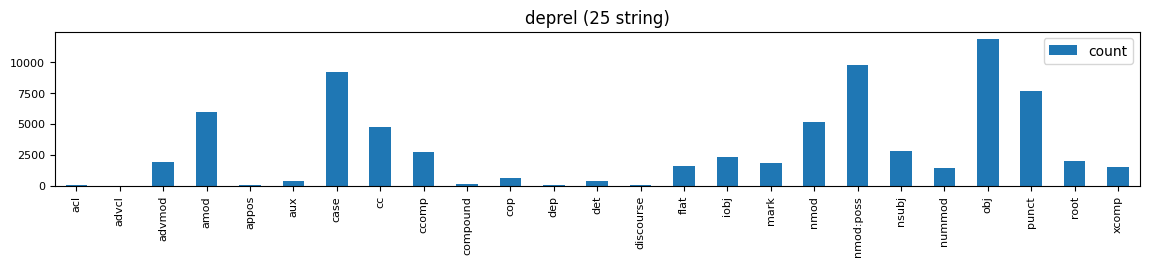

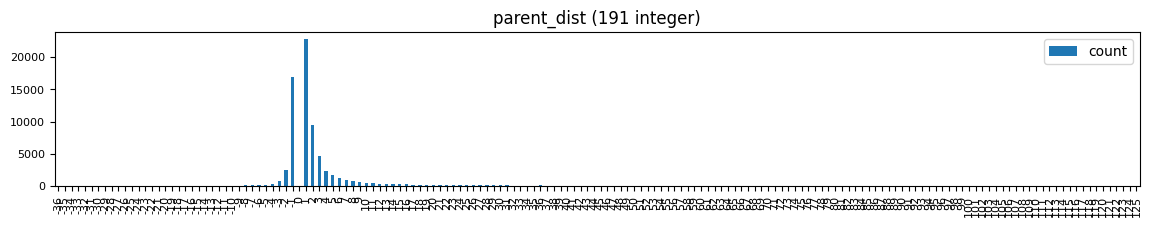

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def plot_size_hist(data_dict, title):
    data_dict = {k: v for k, v in sorted(list(data_dict.items()))}
    df = pd.DataFrame({'count': data_dict.values()}, index=data_dict.keys())
    val_count = len(df.index)
    if df.index.inferred_type == 'integer':
        low = int(df.index.to_series().quantile(.1))
        if low > 0: low = 0
        high = int(df.index.to_series().quantile(.9) + 1)
        df = df.reindex(range(low, high + 1))
        plot = df.plot.bar
    else:
        plot = df.plot.bar
    plot(title=f"{title} ({val_count} {df.index.inferred_type})", figsize=(14, 2), fontsize=8)

stats = None
for sent in tqdm(corpus):
    _, _, stats = query_subtree(sent, sent.to_tree(), stats)
print(stats['is_conseq'])
for k in stats.keys():
    if k in ['is_conseq', 'size', 'depth', 'branching', 'upos', 'deprel', 'parent_dist']:
        plot_size_hist(stats[k], k)

### Do sequences of 2-4 words have meaning? Are they clusterable?
How many configurations are there? 

### Can you collapse a sequence into a smaller node?
aka how many possible contextes does each sequence live under?

ADP>case>NOUN
ADP>case>PRON
ADP>case>VERB
ADP>case>PROPN
ADP>case>ADV
ADP>case>ADJ
ADP>case>X
ADP>case>NUM
ADP>case>DET
ADP>case>AUX
ADP>nsubj>VERB
ADP>nmod>VERB
* في اللاذقية ،
إليكم مثال من باكستان
فتقعد هي لنقف نحن على أعصابنا .
من امين محمد طبارة
بنزين بلا رصاص : استنتاجات في محلها
على الأقل من زمان لم يحملوا مثله .
20 - ذكرت مصادر يهودية في مسوكو أن مجموعة من الوحدات الخاصة الإسرائيلية " تقدم مساعدات " إلى القوات الأمريكية والبريطانية في أفغانستان .
مشرف 1999 هو ذاته في 2002 .
كذلك ، قاطع العراق اجتماعات اللجنة الثلاثية منذ عام 1998 .
أم هل ان اميركا مصرة على ان لا تريد لغيرها ما تريد لنفسها ؟
وردا على سؤال حول اسباب " عدم اطلاق اي طلقة واحدة من الجولان منذ عام 1973 لمقاومة الاحتلال " على مثال ما قام به حزب الله اللبناني الذي دفع الجيش الاسرائيلي الى الانسحاب من جنوب لبنان بعد 22 عاما من الاحتلال ، قال طلاس " ما من شك ان الصمود اسلوب من اساليب المقاومة من خلال التزامنا ما وقعنا عليه " .
في مكان اخر تحاكي الغيمة الحمراء امرأة اعظم جمالا من " بلانش نيج " واكثرها ضرورة للبشرية جمعاء 

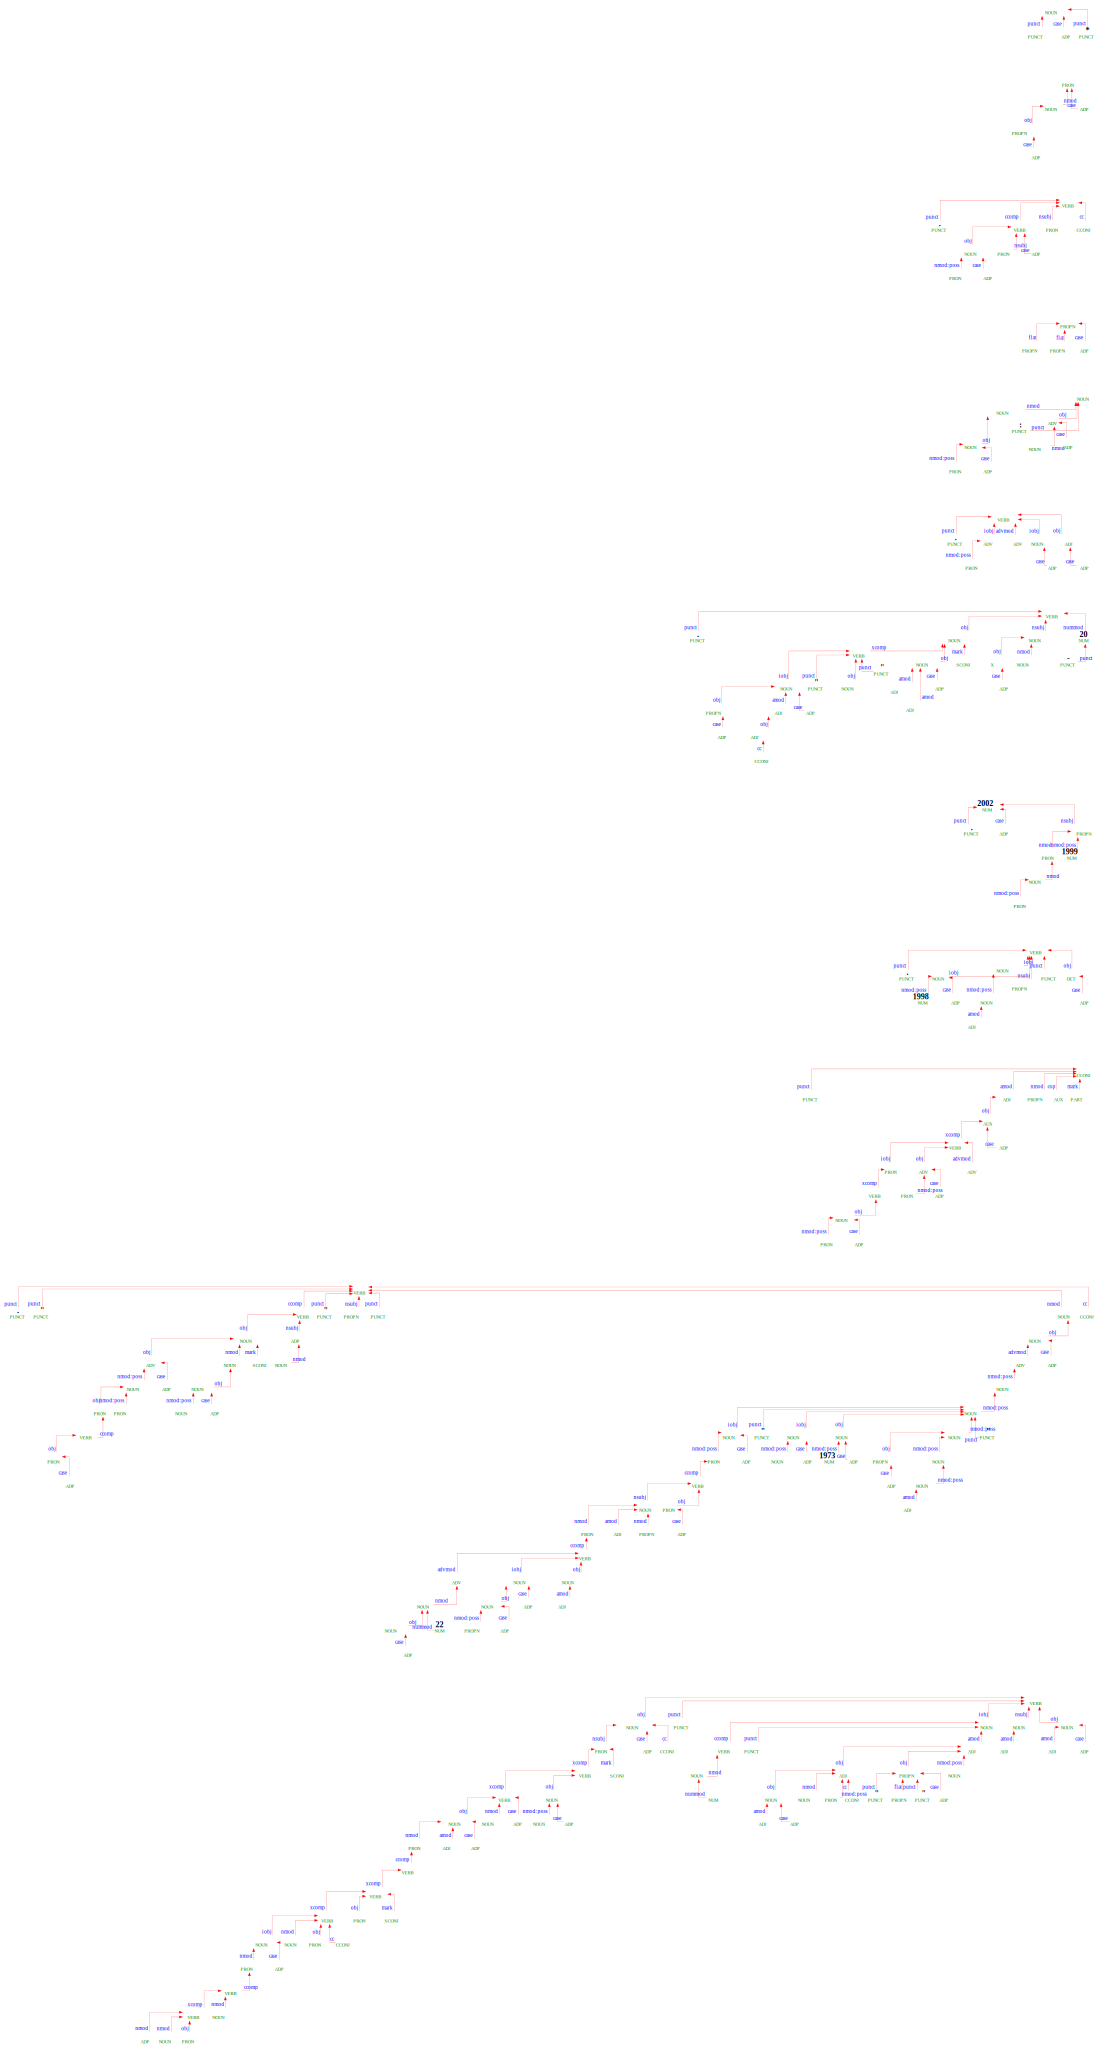

In [5]:
examples = []
for upos_deprel_parent, ex in stats['upos>deprel>parent.examples'].items():
    upos, deprel, parent = upos_deprel_parent.split('>')
    if upos != 'ADP': continue
    print(f"{upos}>{deprel}>{parent}")
    examples.append(ex)
tree_draw(examples)

### Is it possible to collapse from a linear representation?
...If you don't have access to the tree.